<h2>Streaming clustering for anomaly detection</h2>

<h3>Problem formulation</h3>

In this notebook, we focus on the problem of unsupervised anomaly detection in the data produced by the ADXL accelerometer mounted at the small Intel CPU fan. The task is to train a model of normal behavior which can be used in order to classify anomalous events that significantly deviate from the norms described by the model. The normal behavior includes two main patterns: idle and active. These patterns are generated by periodically switching the fan on, letting it rotate for some time and then shutting it down. Examples of anomalous events include:
<ul>
  <li>"Shake" - shaking the table on which the fan is located when the fan is active</li>
  <li>"Tape" - attaching a small piece of tape on one of the fan blades and switching the fan on</li>
  <li>"Stick" - poking a plastic stick into the blades when the fan is active</li>
</ul>

We aim to build the normal behavior model as a set of clusters. This would allow us calssify a new unlabeled input sample based on the distance between this sample and the clusters found: if this distance is above some predefined threshold, the sample is labeled as an anomaly. The resulting code is supposed to be able to run on a small IoT board such as Arduino UNO. This imposes computing and memory constraints which a solution of the problem formulated should satisfy. In particular, due to low amount of RAM, there is no possibility to keep many data samples in memory, and therefore a streaming clustering algorithm should be empoyed. Furthermore, the maximum number of clusters is also limited. Finally, there is need for a low-complexity method to compare several clustering methods to each other in terms of anomaly detection accuracy. Since there is no any information about anomalies during the training, this method should rely solely on the normal data.

<img src="figures/fan/env.jpg" alt="Environment" width="700">

<h3>Data preprocessing</h3>

Import packages needed:

In [460]:
import os
import numpy as np
import pandas as pd
import os.path as osp

from sklearn.manifold import TSNE
from matplotlib import pyplot as pp
from ctypes import cdll, c_short, POINTER
from sklearn.metrics import auc, roc_curve

Specify the task parameters:

In [461]:
np.random.seed(0)  # random seed for results reproducability
series_len = 32  # the length of the time series to sample
dataset_file_offset = 11  # skip few first samples
batch_size = 16  # the training batch size
n_test = 4000  # number of test points from each class

Feature extraction functions:
<ul style="list-style-type:circle">
  <li>simple_features: min, max, mean and std of each component in the time-series</li>
  <li>fft_features: few main frequency components of each component in the time-series</li>
</ul>

In [462]:
def simple_features(X):
    assert len(X.shape) == 3
    m = X.shape[2]
    I = np.ones((m, m))
    I[np.triu_indices(m)] = 0
    E = np.vstack([
        np.hstack([
            np.min(x, 0),
            np.max(x, 0),
            np.mean(x, 0),
            np.std(x, 0),
        ]) for x in X
    ])    
    return E

def fix_fft(x, m=5, n_fft_features=16, fpath='libraries/fix_fft_32k_dll/fix_fft_32k.so'):
    ff = cdll.LoadLibrary(fpath)
    ff.fix_fft.argtypes = [POINTER(c_short), POINTER(c_short), c_short, c_short]
    n = x.shape[0]
    x = [np.array(x[:, i], dtype=int) for i in range(x.shape[1])]
    def fft(re):
        im = [0 for _ in range(n)]
        re_c = (c_short * n)(*re)
        im_c = (c_short * n)(*im)
        ff.fix_fft(re_c, im_c, c_short(m), c_short(0))
        s = np.zeros(n_fft_features)
        for i in range(n_fft_features):
            s[i] = np.round(np.sqrt(re_c[i] * re_c[i] + im_c[i] * im_c[i]) // 2)
        return s 
    mgn = map(fft, x)
    return np.transpose(np.vstack(mgn))

def fft_features(X):
    assert len(X.shape) == 3
    spectrogram = fix_fft(X[0, :, :])
    E = [fix_fft(x) for x in X]
    return simple_features(np.stack(E))

Load the data:

In [463]:
data_dir = 'data/adxl_fan'
subdirs = {}
subdirs['normal'] = ['on_off']
subdirs['anomaly'] = ['stick', 'tape', 'shake']
sample_subdirs = [subdir for subdir in os.listdir(data_dir) if osp.isdir(osp.join(data_dir, subdir)) and subdir in subdirs['normal'] + subdirs['anomaly']]
samples, labels = [], []
xmin, xmax = [], []
for sd in sample_subdirs:
    sample_files = os.listdir(osp.join(data_dir, sd))
    for sf in sample_files:
        fpath = osp.join(osp.join(data_dir, sd), sf)
        if osp.isfile(fpath) and fpath.endswith('.csv'):
            X = pd.read_csv(fpath, header=None).values
            if sd in subdirs['normal']:
                label = 'normal'
            else:
                label = sd
            if label not in labels:
                labels.append(label)
            samples.append(X)

print('Labels:', labels)
with open(f'{data_dir}/labels.txt', 'w')     as f:
    f.write(','.join(labels))

Labels: ['normal', 'shake', 'tape', 'stick']


Create the training and validation sets using the normal data only:

In [464]:
normal_behavior = labels.index('normal')
anomalies = [i for i in range(num_labels) if i != normal_behavior]
n_anomalies = len(anomalies)
input_dim = samples[normal_behavior].shape[1]
num_labels = len(labels)

inds = np.arange(dataset_file_offset, samples[normal_behavior].shape[0], 1)
tr_va, remaining = np.split(inds, [int(0.6 * len(inds))]) 
tr, va = np.split(tr_va, [int(0.7 * len(tr_va))])

X_tr, Y_tr = [], []
for i in tr:
    x = samples[normal_behavior][i : i + series_len, :]
    X_tr.append(x)
    Y_tr.append(0)
X_tr = np.array(X_tr)
Y_tr = np.hstack(Y_tr)

X_va, Y_va = [], []
for i in va:
    x = samples[normal_behavior][i : i + series_len, :]
    X_va.append(x)
    Y_va.append(0)
X_va = np.array(X_va)
Y_va = np.hstack(Y_va)

Create the test set using both the normal and anomalous data:

In [465]:
X_te, Y_te = [], []
for i in range(n_test):
    y = np.random.randint(0, num_labels)
    n = samples[y].shape[0]
    j = np.random.randint(dataset_file_offset, n - series_len)
    x = samples[y][j: j + series_len, :]
    X_te.append(x)
    Y_te.append(y)
X_te = np.array(X_te)
Y_te = np.hstack(Y_te)

Extract features.

In [466]:
extract_features = simple_features
E_tr = extract_features(X_tr)
E_va = extract_features(X_va)
E_te = extract_features(X_te)
ntr = E_tr.shape[0]
xdim = E_tr.shape[1]

<h3>Scalable k-means++</h3>

This algorithm follows the procedure described in Algorithm 2 of study <a href=https://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf>scalable k-means++</a>. The idea is to sample several candidate points independently with probabilities directly proportional to the squared distances from these points to the their closest cluster centroids, i.e. the further a point from its closest centroid the more likely it will be selected as a candidate. After that, a weighted clustering k-means procedure is applied to the union of the centroids and the candidate points with the weight for each sample defined as the number of data points closer to this sample than any other candidate. As one can notice, the number of centroid candidates is significantly smaller than the input batch size and, therefore, the reclustering can be done quickly. Alternatively, the reclustering procedure can be substituted with an approximation algorithm, e.g. <a href=https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf>k-means++</a>.

Clustering parameteres:

In [467]:
nclusters_max = 4  # the maximum number of clusters
l = 4  # the maximum number of candidates

Clustering procedure:

In [468]:
# init min and max values, the number of batches, centroids, and their weights

xmin = np.inf * np.ones(xdim)
xmax = -np.inf * np.ones(xdim)
nbatches = ntr // batch_size
C, W = None, None

# the main clustering loop

for i in range(0, ntr - batch_size, batch_size):
    
    # take a batch
    
    idx = np.arange(i, i + batch_size)
    B = E_tr[idx, :]
    
    # update min and max values
    
    xmin = np.min(np.vstack([xmin, B]), 0)
    xmax = np.max(np.vstack([xmax, B]), 0)
    
    # pick initial centroids

    if C is None:
        C = B[np.random.choice(range(B.shape[0]), nclusters_max, replace=False), :]
        D = np.zeros((B.shape[0], C.shape[0]))
        for j in range(B.shape[0]):
            for k in range(C.shape[0]):
                D[j, k] = np.sum(((B[j, :] - xmin)/(xmax - xmin + 1e-10) - (C[k, :] - xmin)/(xmax - xmin + 1e-10))**2)
        min_dist = np.zeros(D.shape)
        min_dist[range(D.shape[0]), np.argmin(D, axis=1)] = 1
        count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(C.shape[0])])
        W = np.zeros(nclusters_max)
    
    # select candidates

    D = np.zeros((B.shape[0], C.shape[0]))
    for j in range(B.shape[0]):
        for k in range(C.shape[0]):
            D[j, k] = np.sum(((B[j, :] - xmin)/(xmax - xmin + 1e-10) - (C[k, :] - xmin)/(xmax - xmin + 1e-10))**2)
    cost = np.sum(np.min(D, axis=1))
    p = np.min(D, axis=1) / (cost + 1e-10)
    C = np.r_[C, B[np.random.choice(range(len(p)), l, p=p, replace=False),:]]
    
    # assign data to the centroids 
    
    D = np.zeros((B.shape[0], C.shape[0]))
    for j in range(B.shape[0]):
        for k in range(C.shape[0]):
            D[j, k] = np.sum(((B[j, :] - xmin)/(xmax - xmin + 1e-10) - (C[k, :] - xmin)/(xmax - xmin + 1e-10))**2)
    min_dist = np.zeros(D.shape)
    min_dist[range(D.shape[0]), np.argmin(D, axis=1)] = 1
    count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(C.shape[0])])
    for i in range(len(W)):
        count[i] += W[i]
        
    # weighted k-means clustering
        
    n_iters = 100
    centroids = C[:nclusters_max, :]
    for i in range(n_iters):
        
        D = np.zeros((C.shape[0], centroids.shape[0]))
        for j in range(C.shape[0]):
            for k in range(centroids.shape[0]):
                D[j, k] = np.sum(((C[j, :] - xmin) / (xmax - xmin + 1e-10) - (centroids[k, :] - xmin) / (xmax - xmin + 1e-10)) ** 2)
        cl_labels = np.argmin(D, axis=1)
        
        centroids_new = []
        W_new = []
        
        for j in range(nclusters_max):
            idx = np.where(cl_labels == j)[0]
            if len(idx) > 0:
                centroids_new.append(np.sum(count[idx, None] * C[idx, :], axis=0) / (np.sum(count[idx] + 1e-10)))
                W_new.append(np.sum(count[idx]))
            else:
                pass
                
        if np.array_equal(centroids, centroids_new):
            break 
                
        centroids = np.vstack(centroids_new)
        W = np.hstack(W_new)
    C = centroids
        
C_ = (centroids - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)

Apply <a href=https://lvdmaaten.github.io/tsne/>t-SNE</a> for dimensionality reduction:

In [469]:
colors = ['yo', 'rs', 'gv', 'b*']
X_plot = np.vstack([E_te, centroids])
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
xy_all = tsne.fit_transform(np.vstack(X_plot))
c = xy_all[-nclusters_max:, :]

Plot few data points from each class and the cluster centroids found:  

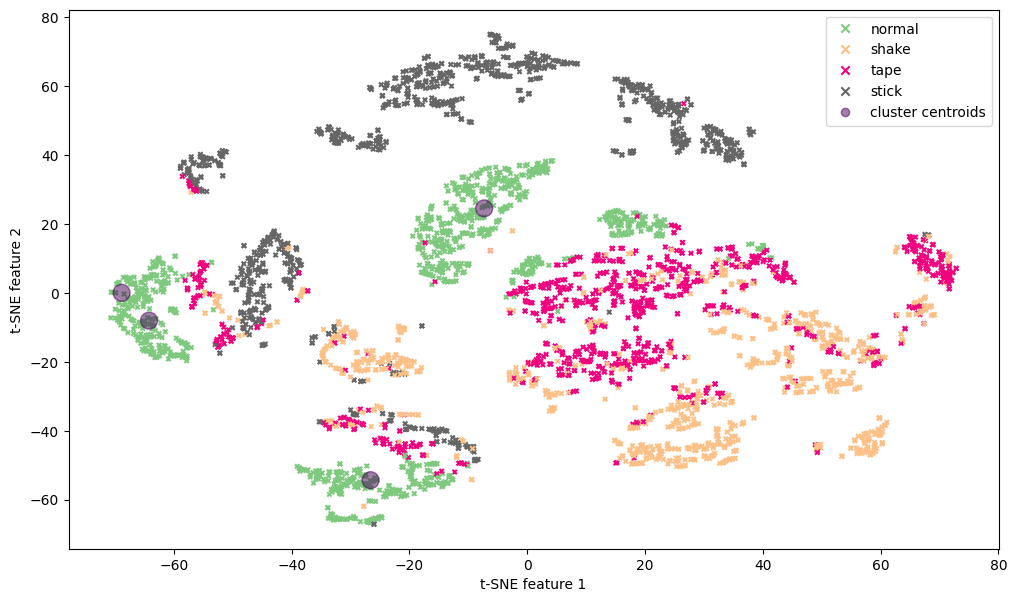

In [470]:
pp.style.use('default')
pp.figure(figsize=(12, 7))
scatter_points = pp.scatter(xy_all[:-nclusters_max, 0], xy_all[:-nclusters_max, 1], c = Y_te, s = 10, cmap = 'Accent', marker='x')
pp.xlabel('t-SNE feature 1',fontsize=10)
pp.ylabel('t-SNE feature 2',fontsize=10)
scatter_centroids = pp.scatter(c[:, 0], c[:, 1], c = np.zeros(nclusters_max), s = 150, alpha = 0.5);   
pp.legend(
    scatter_points.legend_elements()[0] + scatter_centroids.legend_elements()[0], 
    labels + ['cluster centroids'], 
    loc = 0
)
pp.show()
pp.close()

Alpha = 7.069999999999894
Accuracy = 64.81665014866203, precision = 99.99999999996754, tpr = 40.76666666666531, fpr = 0.0



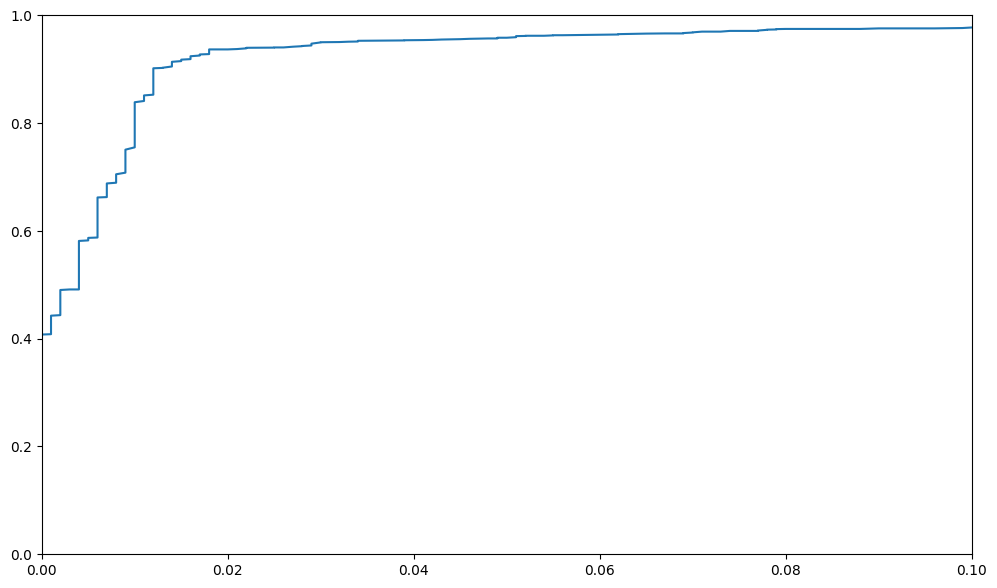

Results for anomaly: shake
Accuracy = 76.88888888888889, precision = 99.99999999998204, tpr = 54.34146341462884, fpr = 0.0
Results for anomaly: tape
Accuracy = 68.82984159427696, precision = 99.9999999999712, tpr = 36.259143155691085, fpr = 0.0
Results for anomaly: stick
Accuracy = 65.36174430128841, precision = 99.99999999996867, tpr = 31.335952848719906, fpr = 0.0


In [471]:
E_va = extract_features(X_va)
E_te = extract_features(X_te)
E_va_ = (E_va - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
E_te_ = (E_te - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
reals = np.array(Y_te)

D_va = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_va = np.argmin(D_va, axis=1)
dists_va = np.min(D_va, axis=1)
    
nte = len(Y_te)
D_te = np.linalg.norm(E_te_[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_te = np.argmin(D_te, axis=1)
dists_te = np.min(D_te, axis=1)
reals = np.zeros(nte)
reals[np.where(Y_te != normal_behavior)] = 1
    
fpr = 100
alpha = 0
alpha_max = 100
alpha_step = 0.01
fprs, tprs = [], []
while (fpr > 0): 
    dist_thrs = np.zeros(nclusters_max)
    for k in range(nclusters_max):
        idx = np.where(cl_labels_va == k)[0]
        dist_thrs[k] = np.mean(dists_va[idx]) + alpha * np.std(dists_va[idx])
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = np.zeros(nte)
    predictions[np.where(dists_te > pred_thrs)[0]] = 1
    fpr = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0]))
    tpr = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0]))
    fprs.append(fpr)
    tprs.append(tpr)
    alpha += alpha_step
alpha_best = alpha
print(f'Alpha = {alpha_best}\nAccuracy = {accuracy}, precision = {precision}, tpr = {tpr * 100}, fpr = {fpr * 100}\n')

pp.figure(figsize=(12,7))
pp.plot(np.array(fprs), np.array(tprs))
pp.xlim([0, 0.1])
pp.ylim([0, 1])
pp.show()
pp.close()
    
for i, anomaly in enumerate(anomalies):
    print(f'Results for anomaly: {labels[anomaly]}')
    idx = np.where((Y_te == anomaly) | (Y_te == normal_behavior))[0]
    nte = len(idx)
    D = np.linalg.norm(E_te_[idx, None, :] - C_[None, :, :], axis=-1)
    cl_labels = np.argmin(D, axis=1)
    dists = np.min(D, axis=1)
    pred_thrs = dist_thrs[cl_labels]
    reals = np.zeros(nte)
    reals[np.where(Y_te[idx] == anomaly)] = 1
    predictions = np.zeros(nte)
    predictions[np.where(dists > pred_thrs)[0]] = 1
    accuracy = len(np.where(predictions == reals)[0]) / nte * 100
    precision = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(predictions == 1)[0])) * 100
    tpr = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0])) * 100
    fpr = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0])) * 100
    print(f'Accuracy = {accuracy}, precision = {precision}, tpr = {tpr}, fpr = {fpr}')

EM and MV metrics:

In [472]:
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() - t * (s_unif > u).sum() / n_generated * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax

def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv

Test EM and MV metrics:

0.0065290254999992815 0.019828280000000004


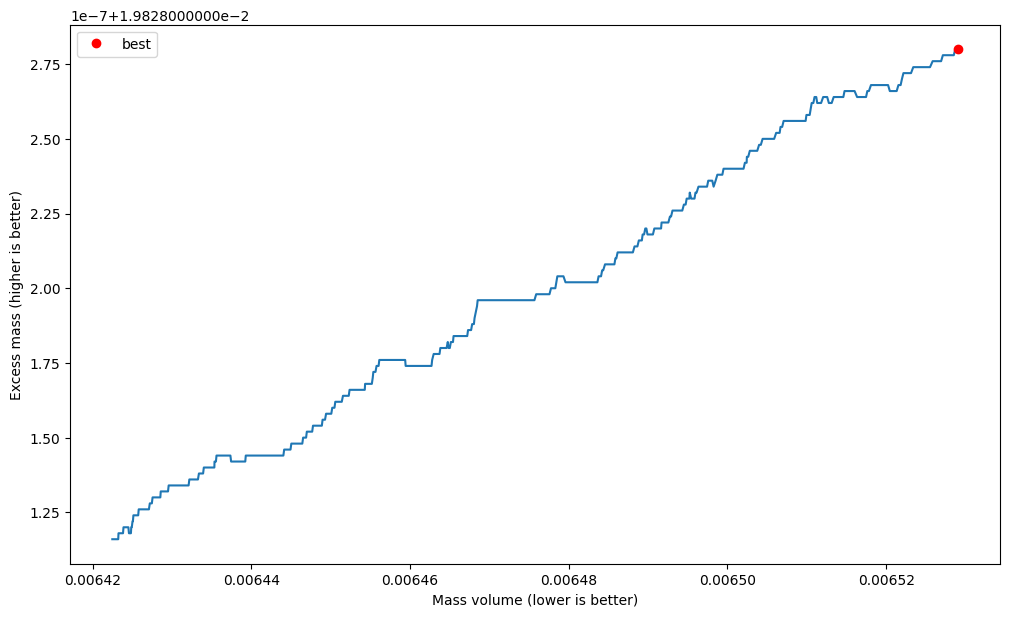

In [473]:
t_max = 0.99
n_generated = 100000
volume_support = (np.ones(E_te.shape[1]) - np.zeros(E_te.shape[1])).prod()
t = np.arange(0, 1 / volume_support, 0.01 / volume_support)
alpha_min = 0.99
alpha_max = 0.99999
axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)

X_test = E_te[np.where(Y_te == normal_behavior)[0], :]
X_test = (X_test - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
Y_test = np.zeros(X_test.shape[0])
nte = len(Y_test)

X_unif = np.random.uniform(np.zeros(E_te.shape[1]), np.ones(E_te.shape[1]), size=(n_generated, X_test.shape[1]))

D_te = np.linalg.norm(X_test[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_te = np.argmin(D_te, axis=1)
dists_te = np.min(D_te, axis=1)

D_unif = np.linalg.norm(X_unif[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_unif = np.argmin(D_unif, axis=1)
dists_unif = np.min(D_unif, axis=1)

ems = []
mvs = []

for alpha in np.arange(alpha_best, 15, 0.01):

    dist_thrs = np.zeros(nclusters_max)
    for k in range(nclusters_max):
        idx = np.where(cl_labels_va == k)[0]
        dist_thrs[k] = np.mean(dists_va[idx]) + alpha * np.std(dists_va[idx])
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = (pred_thrs - dists_te) / (pred_thrs + 1e-10)

    pred_thrs = dist_thrs[cl_labels_unif]
    predictions_unif = (pred_thrs - dists_unif) / (pred_thrs + 1e-10)
    auc_em, em_, amax = em(t, t_max, volume_support, predictions_unif, predictions, n_generated)
    auc_mv, mv_ = mv(axis_alpha, volume_support, predictions_unif, predictions, n_generated)
    ems.append(auc_em)
    mvs.append(auc_mv)
print(mvs[0], ems[0])
    
pp.figure(figsize=(12, 7))
pp.plot(np.array(mvs), np.array(ems))
pp.plot(np.array(mvs)[:1], np.array(ems)[:1], 'ro', label='best')
pp.legend()
pp.xlabel('Mass volume (lower is better)')
pp.ylabel('Excess mass (higher is better)')
pp.show()
pp.close()

<h3>Birch k-means</h3>

In [474]:
colors = ['yo', 'rs', 'gv', 'b*']
X_plot = np.vstack([E_te, C])
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
xy_all = tsne.fit_transform(np.vstack(X_plot))
c = xy_all[-C.shape[0]:, :]

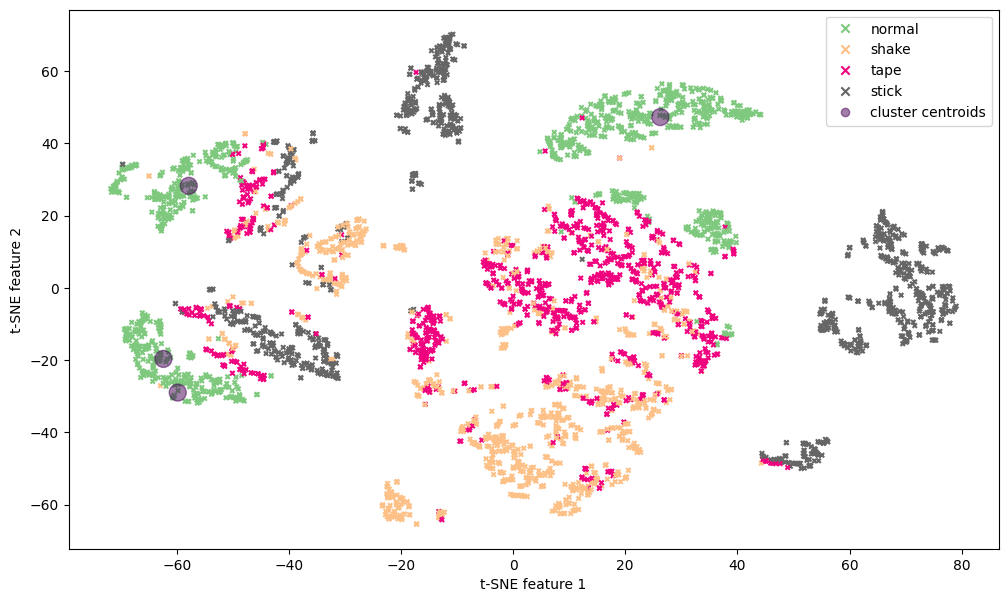

In [475]:
pp.style.use('default')
pp.figure(figsize=(12, 7))
scatter_points = pp.scatter(xy_all[:-C.shape[0], 0], xy_all[:-C.shape[0], 1], c = Y_te, s = 10, cmap = 'Accent', marker='x')
pp.xlabel('t-SNE feature 1',fontsize=10)
pp.ylabel('t-SNE feature 2',fontsize=10)
scatter_centroids = pp.scatter(c[:, 0], c[:, 1], c = np.zeros(C.shape[0]), s = 150, alpha = 0.5);   
pp.legend(
    scatter_points.legend_elements()[0] + scatter_centroids.legend_elements()[0], 
    labels + ['cluster centroids'], 
    loc = 0
)
pp.show()
pp.close()

[1 3 3 ... 3 3 3]
Alpha = 7.069999999999894
Accuracy = 65.36174430128841, precision = 99.99999999996867, tpr = 40.76666666666531, fpr = 0.0



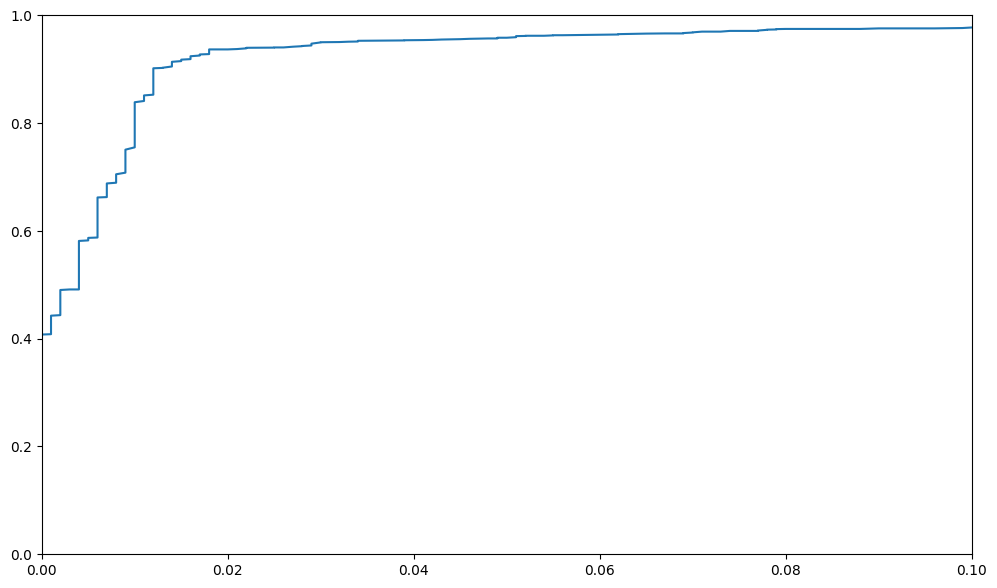

Results for anomaly: shake
Accuracy = 76.88888888888889, precision = 99.99999999998204, tpr = 54.34146341462884, fpr = 0.0
Results for anomaly: tape
Accuracy = 68.82984159427696, precision = 99.9999999999712, tpr = 36.259143155691085, fpr = 0.0
Results for anomaly: stick
Accuracy = 65.36174430128841, precision = 99.99999999996867, tpr = 31.335952848719906, fpr = 0.0


In [476]:
D_va = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_va = np.argmin(D_va, axis=1)
dists_va = np.min(D_va, axis=1)
    
nte = len(Y_te)
D_te = np.linalg.norm(E_te_[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_te = np.argmin(D_te, axis=1)
dists_te = np.min(D_te, axis=1)
print(cl_labels_te)
reals = np.zeros(nte)
reals[np.where(Y_te != normal_behavior)] = 1
    
fpr = 100
alpha = 0
alpha_max = 100
alpha_step = 0.01
fprs, tprs = [], []
while (fpr > 0): 
    dist_thrs = np.zeros(C.shape[0])
    for k in range(C.shape[0]):
        idx = np.where(cl_labels_va == k)[0]
        dist_thrs[k] = np.mean(dists_va[idx]) + alpha * np.std(dists_va[idx])
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = np.zeros(nte)
    predictions[np.where(dists_te > pred_thrs)[0]] = 1
    fpr = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0]))
    tpr = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0]))
    fprs.append(fpr)
    tprs.append(tpr)
    alpha += alpha_step
alpha_best = alpha
print(f'Alpha = {alpha_best}\nAccuracy = {accuracy}, precision = {precision}, tpr = {tpr * 100}, fpr = {fpr * 100}\n')

pp.figure(figsize=(12, 7))
pp.plot(np.array(fprs), np.array(tprs))
pp.xlim([0, 0.1])
pp.ylim([0, 1])
pp.show()
pp.close()
    
for i, anomaly in enumerate(anomalies):
    print(f'Results for anomaly: {labels[anomaly]}')
    idx = np.where((Y_te == anomaly) | (Y_te == normal_behavior))[0]
    nte = len(idx)
    D = np.linalg.norm(E_te_[idx, None, :] - C_[None, :, :], axis=-1)
    cl_labels = np.argmin(D, axis=1)
    dists = np.min(D, axis=1)
    pred_thrs = dist_thrs[cl_labels]
    reals = np.zeros(nte)
    reals[np.where(Y_te[idx] == anomaly)] = 1
    predictions = np.zeros(nte)
    predictions[np.where(dists > pred_thrs)[0]] = 1
    accuracy = len(np.where(predictions == reals)[0]) / nte * 100
    precision = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(predictions == 1)[0])) * 100
    tpr = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0])) * 100
    fpr = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0])) * 100
    print(f'Accuracy = {accuracy}, precision = {precision}, tpr = {tpr}, fpr = {fpr}')

0.0065290254999992815 0.019828280000000004


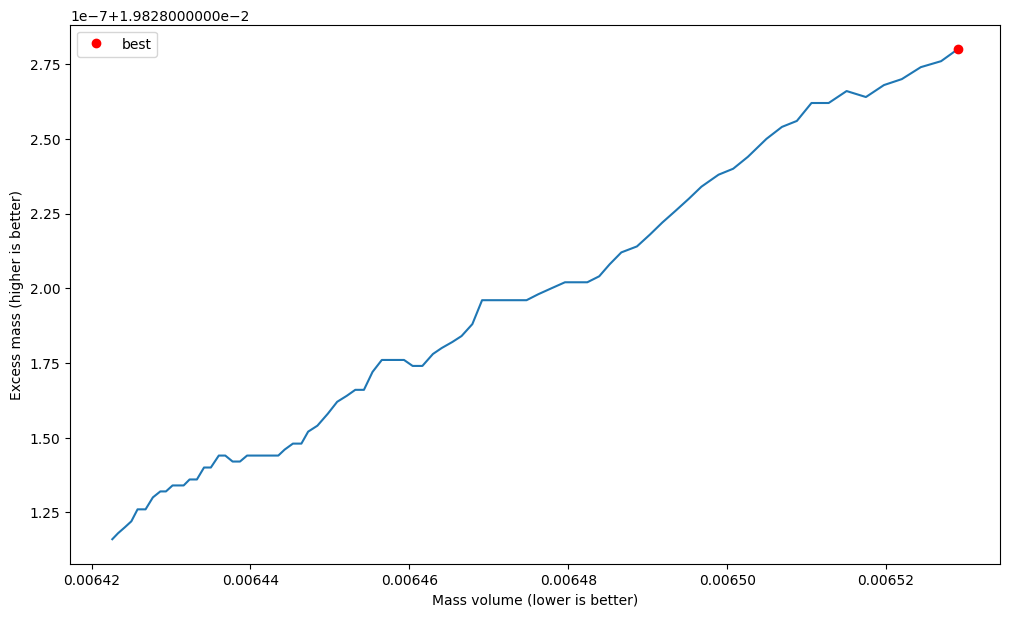

In [477]:
D_te = np.linalg.norm(X_test[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_te = np.argmin(D_te, axis=1)
dists_te = np.min(D_te, axis=1)

D_unif = np.linalg.norm(X_unif[:, None, :] - C_[None, :, :], axis=-1)
cl_labels_unif = np.argmin(D_unif, axis=1)
dists_unif = np.min(D_unif, axis=1)

ems = []
mvs = []

for alpha in np.arange(alpha_best, 15, 0.1):

    dist_thrs = np.zeros(C.shape[0])
    for k in range(C.shape[0]):
        idx = np.where(cl_labels_va == k)[0]
        dist_thrs[k] = np.mean(dists_va[idx]) + alpha * np.std(dists_va[idx])
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = (pred_thrs - dists_te) / (pred_thrs + 1e-10)

    pred_thrs = dist_thrs[cl_labels_unif]
    predictions_unif = (pred_thrs - dists_unif) / (pred_thrs + 1e-10)
    auc_em, em_, amax = em(t, t_max, volume_support, predictions_unif, predictions, n_generated)
    auc_mv, mv_ = mv(axis_alpha, volume_support, predictions_unif, predictions, n_generated)
    ems.append(auc_em)
    mvs.append(auc_mv)
print(mvs[0], ems[0])

pp.figure(figsize=(12, 7))
pp.plot(np.array(mvs), np.array(ems))
pp.plot(np.array(mvs)[:1], np.array(ems)[:1], 'ro', label='best')
pp.legend()
pp.xlabel('Mass volume (lower is better)')
pp.ylabel('Excess mass (higher is better)')
pp.show()
pp.close()